In [1]:
import pandas as pd
import numpy as np
from multiprocessing import process
from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

## Explore return rates by transactions and time frame

<p> This workbook takes raw data as date, customer_id and asin and delivers EDA on what is the return rate after various timeframes </p>

<p> The hypothesis is, based on granular data up to transaction level, that customers are emotional in the sense that they have short attention span and generally buy in chunks, ie once they purchased something, the next one is more likely to be in the very near future than in a distant one. </p>
<p> In other words, depending on the number of previous transactions, return rate within 10 next days has the highest probability, at least 20% <p>


In [2]:
#df = pd.read_csv("Z:00_ETL/return_rates/return_rates_4.txt", sep="\t") #too large to be processed locally at once

In [3]:
iter_csv = pd.read_csv("Z:00_ETL/return_rates/return_rates_4.txt", sep="\t", chunksize=1000000, engine='python')
df = pd.concat([chunk for chunk in iter_csv])

In [4]:
print(df.shape, df['encrypted_customer_id'].nunique())
df.head()

(31058257, 4) 2500000


,transaction_date_local,encrypted_customer_id,units,rank
0,2015-12-20,A021077924PQPL0D8DNBY,1,1
1,2016-01-31,A021077924PQPL0D8DNBY,1,2
2,2016-09-17,A021077924PQPL0D8DNBY,1,3
3,2017-05-25,A021077924PQPL0D8DNBY,1,4
4,2017-05-29,A021077924PQPL0D8DNBY,1,5


In [5]:
df[df['encrypted_customer_id'] == 'A01699183EOH5ZVXY8Z01']

,transaction_date_local,encrypted_customer_id,units,rank


In [6]:
df['encrypted_customer_id'].nunique()

2500000

In [7]:
def add_dates_to_df(df):
    """the function calculates first 5 purchase dates for each customer and appends to the initial dataset"""
    #df_r['rank'] = df_r.groupby('encrypted_customer_id')['transaction_date_local'].rank(ascending=True) #takes really long
    
    dataframe = []
    for i in range(0,11):
        #give the range of time differences
        
        t = pd.DataFrame(df.groupby("encrypted_customer_id")['transaction_date_local'].nth(i).reset_index()) 
    #k = t.iloc[:,1]
    #df['col%d' %i] = pd.merge(left=df,right=t,left_on='encrypted_customer_id',right_on='encrypted_customer_id', how='left')
        dataframe.append(t)
    
    temp = reduce(lambda x,y:pd.merge(x,y,on = 'encrypted_customer_id',how='outer'), dataframe)   
    new = pd.merge(df,temp,on = 'encrypted_customer_id', how = 'left' )
    new.columns = ['transaction_date','encrypted_customer_id','units',
                  'rank','first_date','second_date','third_date','fourth_date','fifth_date','sixth_date','seven_date',
                  'eighth_date','ninth_date','tenth_date','eleventh_date']
    
    return new

In [8]:
new_df = add_dates_to_df(df)

In [9]:
new_df.tail()

,transaction_date,encrypted_customer_id,units,rank,first_date,second_date,third_date,fourth_date,fifth_date,sixth_date,seven_date,eighth_date,ninth_date,tenth_date,eleventh_date
31058252,2017-10-31,AZXQGY74R5CZT,1,43,2016-10-14,2016-10-15,2016-10-22,2016-10-25,2016-11-12,2016-11-18,2016-11-26,2016-11-30,2016-12-10,2016-12-17,2016-12-25
31058253,2018-01-07,AZXQGY74R5CZT,1,44,2016-10-14,2016-10-15,2016-10-22,2016-10-25,2016-11-12,2016-11-18,2016-11-26,2016-11-30,2016-12-10,2016-12-17,2016-12-25
31058254,2018-02-09,AZXQGY74R5CZT,2,45,2016-10-14,2016-10-15,2016-10-22,2016-10-25,2016-11-12,2016-11-18,2016-11-26,2016-11-30,2016-12-10,2016-12-17,2016-12-25
31058255,2018-03-08,AZXQGY74R5CZT,1,46,2016-10-14,2016-10-15,2016-10-22,2016-10-25,2016-11-12,2016-11-18,2016-11-26,2016-11-30,2016-12-10,2016-12-17,2016-12-25
31058256,2018-03-17,AZXQGY74R5CZT,1,47,2016-10-14,2016-10-15,2016-10-22,2016-10-25,2016-11-12,2016-11-18,2016-11-26,2016-11-30,2016-12-10,2016-12-17,2016-12-25


In [10]:
def add_max_rank(df):
    t = pd.DataFrame(df.groupby("encrypted_customer_id")['rank'].max().reset_index())
    t.columns = ['encrypted_customer_id','max_rank']
    
    m = pd.merge(left=df,right=t,
                 left_on='encrypted_customer_id', right_on='encrypted_customer_id', how = 'left')
    return m

In [11]:
new_df = add_max_rank(new_df)

In [12]:
print(new_df[new_df['encrypted_customer_id'] == 'A01699183EOH5ZVXY8Z01'].nunique())
new_df[new_df['encrypted_customer_id'] == 'A01699183EOH5ZVXY8Z01']

transaction_date        NaN
encrypted_customer_id   NaN
units                   NaN
rank                    NaN
first_date              NaN
second_date             NaN
third_date              NaN
fourth_date             NaN
fifth_date              NaN
sixth_date              NaN
seven_date              NaN
eighth_date             NaN
ninth_date              NaN
tenth_date              NaN
eleventh_date           NaN
max_rank                NaN
dtype: float64


,transaction_date,encrypted_customer_id,units,rank,first_date,second_date,third_date,fourth_date,fifth_date,sixth_date,seven_date,eighth_date,ninth_date,tenth_date,eleventh_date,max_rank


In [13]:
def calculate_time_diff(df):
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['first_date']       = pd.to_datetime(df['first_date'])
    df['second_date']      = pd.to_datetime(df['second_date'])
    df['third_date']       = pd.to_datetime(df['third_date'])
    df['fourth_date']      = pd.to_datetime(df['fourth_date'])
    df['fifth_date']       = pd.to_datetime(df['fifth_date'])
    df['sixth_date']       = pd.to_datetime(df['sixth_date'])
    df['seven_date']       = pd.to_datetime(df['seven_date'])
    df['eighth_date']      = pd.to_datetime(df['eighth_date'])
    df['ninth_date']       = pd.to_datetime(df['ninth_date'])
    df['tenth_date']       = pd.to_datetime(df['tenth_date'])
    df['eleventh_date']    = pd.to_datetime(df['eleventh_date'])
    
    
    
    
    df['diff_vs_first']    = (df['transaction_date'] - df['first_date']) / np.timedelta64(1,"D")
    df['diff_vs_second']   = (df['transaction_date'] - df['second_date']) / np.timedelta64(1,"D")
    df['diff_vs_third']    = (df['transaction_date'] - df['third_date']) / np.timedelta64(1,"D")
    df['diff_vs_fourth']   = (df['transaction_date'] - df['fourth_date']) / np.timedelta64(1,"D")
    df['diff_vs_fifth']    = (df['transaction_date'] - df['fifth_date']) / np.timedelta64(1,"D")
    df['diff_vs_sixth']    = (df['transaction_date'] - df['sixth_date']) / np.timedelta64(1,"D")
    df['diff_vs_seventh']  = (df['transaction_date'] - df['seven_date']) / np.timedelta64(1,"D")
    df['diff_vs_eighth']   = (df['transaction_date'] - df['eighth_date']) / np.timedelta64(1,"D")
    df['diff_vs_ninth']    = (df['transaction_date'] - df['ninth_date']) / np.timedelta64(1,"D")
    df['diff_vs_tenth']    = (df['transaction_date'] - df['tenth_date']) / np.timedelta64(1,"D")
    df['diff_vs_eleventh'] = (df['transaction_date'] - df['eleventh_date']) / np.timedelta64(1,"D")
    
    
       
    df = df.fillna(0)
    return df

In [14]:
new_df=calculate_time_diff(new_df)

In [15]:
new_df.head()

,transaction_date,encrypted_customer_id,units,rank,first_date,second_date,third_date,fourth_date,fifth_date,sixth_date,...,diff_vs_second,diff_vs_third,diff_vs_fourth,diff_vs_fifth,diff_vs_sixth,diff_vs_seventh,diff_vs_eighth,diff_vs_ninth,diff_vs_tenth,diff_vs_eleventh
0,2015-12-20,A021077924PQPL0D8DNBY,1,1,2015-12-20,2016-01-31,2016-09-17,2017-05-25,2017-05-29,2017-05-30,...,-42.0,-272.0,-522.0,-526.0,-527.0,-651.0,0.0,0.0,0.0,0.0
1,2016-01-31,A021077924PQPL0D8DNBY,1,2,2015-12-20,2016-01-31,2016-09-17,2017-05-25,2017-05-29,2017-05-30,...,0.0,-230.0,-480.0,-484.0,-485.0,-609.0,0.0,0.0,0.0,0.0
2,2016-09-17,A021077924PQPL0D8DNBY,1,3,2015-12-20,2016-01-31,2016-09-17,2017-05-25,2017-05-29,2017-05-30,...,230.0,0.0,-250.0,-254.0,-255.0,-379.0,0.0,0.0,0.0,0.0
3,2017-05-25,A021077924PQPL0D8DNBY,1,4,2015-12-20,2016-01-31,2016-09-17,2017-05-25,2017-05-29,2017-05-30,...,480.0,250.0,0.0,-4.0,-5.0,-129.0,0.0,0.0,0.0,0.0
4,2017-05-29,A021077924PQPL0D8DNBY,1,5,2015-12-20,2016-01-31,2016-09-17,2017-05-25,2017-05-29,2017-05-30,...,484.0,254.0,4.0,0.0,-1.0,-125.0,0.0,0.0,0.0,0.0


# Brute force approach

<p> The idea is to retrieve all corresponding ranks and look at distribution from previous purchase to the current </p>
<p> Basis is the number of customers who made the previous purchase </p>

In [16]:
def make_subset(df, rank):
    return df[(df['max_rank'] == rank) & (df['rank'] == rank)]

In [17]:
def set_buckets(df, column):
    df = df.copy()
    df['buckets'] = 'na'
    
    df['buckets'].loc[(df[column] <= 10) & (df[column]) > 0.0] =  "10days"
    df['buckets'].loc[ (df[column] > 10 ) 
                            & (df[column] <= 20) ] =  "20days"
    df['buckets'].loc[ (df[column] > 20 ) 
                            & (df[column] <= 30) ] =  "30days"
    df['buckets'].loc[ (df[column] > 30 ) 
                            & (df[column] <= 40) ] =  "40days"
    df['buckets'].loc[ (df[column] > 40 ) 
                            & (df[column] <= 50) ] =  "50days"
 
    df['buckets'].loc[ (df[column] > 50 ) 
                            & (df[column] <= 60) ] =  "60days"

    df['buckets'].loc[ (df[column] > 60 ) 
                            & (df[column] <= 90) ] =  "90days"
    df['buckets'].loc[ (df[column] > 90 ) 
                            & (df[column] <= 120) ] =  "120days"
    df['buckets'].loc[ (df[column] > 120 ) 
                            & (df[column] <= 364) ] =  "364days"
    
    df['buckets'].loc[ (df[column] > 364 ) ] =  "365+days"
    
    
    return df

In [18]:
def combine_with_bases(df1,df2,rank1):
    t = pd.DataFrame(df1.groupby("buckets").size().reset_index())
    t['total'] = df2[df2['max_rank'] == rank1-1]['encrypted_customer_id'].nunique()
    t.columns = ['buckets','size','total']
    t['share'] = t['size'] / t['total']
    t['name'] = rank1
    return t

# Make analysis mutually exclusive

### Sanity check

In [19]:
s = pd.DataFrame(new_df.groupby("encrypted_customer_id")['max_rank'].max().reset_index())
s = pd.DataFrame(s.groupby("max_rank").size().reset_index())
s.columns = ['rank','size']

In [20]:
print(s['size'].sum())
s['total'] = s['size'].sum()
s['share'] = s['size'] / s['total']
s.head()

2500000


,rank,size,total,share
0,1,676185,2500000,0.270474
1,2,312071,2500000,0.124828
2,3,201112,2500000,0.080445
3,4,145739,2500000,0.058296
4,5,113338,2500000,0.045335


In [21]:
def combine_for_rest(df):
    a0 = pd.DataFrame(df.groupby("encrypted_customer_id")['rank'].max().reset_index())
    
    a1 = pd.DataFrame(df.groupby("encrypted_customer_id")['transaction_date'].min().reset_index())
    a2 = pd.DataFrame(df.groupby("encrypted_customer_id")['transaction_date'].max().reset_index())
    
    t = pd.merge(left=a0, right=a1, left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = 'left')
    t = pd.merge(left=t, right=a2, left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = 'left')
    t.columns = ['encrypted_customer_id', 'total_transactions','first_date','last_date']
    t['diff'] = (t['last_date'] - t['first_date']) / np.timedelta64(1,"D")
    t['avg_freq'] = t['diff'] / (t['total_transactions'] - 1)
    
    return t

## Start with rank 2

In [22]:
#It means customers made in total 2 transactions in their lifetime
rank2 = make_subset(new_df,2)
rank2  = set_buckets(rank2,"diff_vs_first")
rank2 = combine_with_bases(rank2,new_df,2)
rank2

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,58666,676185,0.086760,2
1,120days,18547,676185,0.027429,2
2,20days,21580,676185,0.031914,2
3,30days,16878,676185,0.024961,2
4,364days,78746,676185,0.116456,2
5,365+days,59105,676185,0.087410,2
6,40days,12563,676185,0.018579,2
7,50days,12118,676185,0.017921,2
8,60days,9640,676185,0.014256,2
9,90days,24228,676185,0.035830,2


## Proceed with rank 3

In [23]:
#It means customers made in total 3 transactions in their lifetime 
rank3 = make_subset(new_df,3)
rank3  = set_buckets(rank3,"diff_vs_second")
rank3 = combine_with_bases(rank3,new_df,3)
rank3

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,40044,312071,0.128317,3
1,120days,13228,312071,0.042388,3
2,20days,16633,312071,0.053299,3
3,30days,13300,312071,0.042619,3
4,364days,49038,312071,0.157137,3
5,365+days,24155,312071,0.077402,3
6,40days,9615,312071,0.030810,3
7,50days,9501,312071,0.030445,3
8,60days,7428,312071,0.023802,3
9,90days,18170,312071,0.058224,3


## Proceed with rank 4

In [24]:
#It means customers made in total 4 transactions in their lifetime 
rank4 = make_subset(new_df,4)
rank4  = set_buckets(rank4,"diff_vs_third")
rank4 = combine_with_bases(rank4,new_df,4)
rank4

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,30706,201112,0.152681,4
1,120days,9942,201112,0.049435,4
2,20days,13405,201112,0.066654,4
3,30days,10732,201112,0.053363,4
4,364days,33100,201112,0.164585,4
5,365+days,12424,201112,0.061777,4
6,40days,7779,201112,0.038680,4
7,50days,7661,201112,0.038093,4
8,60days,5758,201112,0.028631,4
9,90days,14232,201112,0.070767,4


## Proceed with rank 5

In [25]:
#It means customers made in total 5 transactions in their lifetime 
rank5 = make_subset(new_df,5)
rank5  = set_buckets(rank5,"diff_vs_fourth")
rank5 = combine_with_bases(rank5,new_df,5)
rank5

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,24964,145739,0.171293,5
1,120days,7866,145739,0.053973,5
2,20days,11180,145739,0.076712,5
3,30days,8951,145739,0.061418,5
4,364days,24026,145739,0.164856,5
5,365+days,7379,145739,0.050632,5
6,40days,6368,145739,0.043695,5
7,50days,6342,145739,0.043516,5
8,60days,4761,145739,0.032668,5
9,90days,11501,145739,0.078915,5


## Proceed with rank 6

In [26]:
#It means customers made in total 6 transactions in their lifetime 
rank6 = make_subset(new_df,6)
rank6  = set_buckets(rank6,"diff_vs_fifth")
rank6 = combine_with_bases(rank6,new_df,6)
rank6

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,21166,113338,0.186751,6
1,120days,6472,113338,0.057104,6
2,20days,9612,113338,0.084808,6
3,30days,7664,113338,0.067621,6
4,364days,18193,113338,0.160520,6
5,365+days,4730,113338,0.041734,6
6,40days,5613,113338,0.049524,6
7,50days,5484,113338,0.048386,6
8,60days,4078,113338,0.035981,6
9,90days,9572,113338,0.084455,6


## Proceed with rank 7

In [27]:
rank7 = make_subset(new_df,7)
rank7  = set_buckets(rank7,"diff_vs_sixth")
rank7 = combine_with_bases(rank7,new_df,7)
rank7

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,18495,92584,0.199765,7
1,120days,5317,92584,0.057429,7
2,20days,8474,92584,0.091528,7
3,30days,6836,92584,0.073836,7
4,364days,14127,92584,0.152586,7
5,365+days,3359,92584,0.036281,7
6,40days,4925,92584,0.053195,7
7,50days,4737,92584,0.051164,7
8,60days,3445,92584,0.037209,7
9,90days,8261,92584,0.089227,7


## Proceed with rank 8

In [28]:
rank8 = make_subset(new_df,8)
rank8  = set_buckets(rank8,"diff_vs_seventh")
rank8 = combine_with_bases(rank8,new_df,8)
rank8

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,16126,77976,0.206807,8
1,120days,4361,77976,0.055927,8
2,20days,7595,77976,0.097402,8
3,30days,6091,77976,0.078114,8
4,364days,11264,77976,0.144455,8
5,365+days,2396,77976,0.030727,8
6,40days,4279,77976,0.054876,8
7,50days,4250,77976,0.054504,8
8,60days,2947,77976,0.037794,8
9,90days,6790,77976,0.087078,8


## Proceed with rank 9

In [29]:
rank9 = make_subset(new_df,9)
rank9  = set_buckets(rank9,"diff_vs_eighth")
rank9 = combine_with_bases(rank9,new_df,9)
rank9

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,14361,66099,0.217265,9
1,120days,3694,66099,0.055886,9
2,20days,6834,66099,0.103390,9
3,30days,5322,66099,0.080516,9
4,364days,8798,66099,0.133103,9
5,365+days,1736,66099,0.026264,9
6,40days,3714,66099,0.056188,9
7,50days,3817,66099,0.057747,9
8,60days,2569,66099,0.038866,9
9,90days,5921,66099,0.089578,9


## Proceed with rank 10

In [30]:
rank10 = make_subset(new_df,10)
rank10  = set_buckets(rank10,"diff_vs_ninth")
rank10  = combine_with_bases(rank10,new_df,10)
rank10

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,12957,56766,0.228253,10
1,120days,3163,56766,0.055720,10
2,20days,6354,56766,0.111933,10
3,30days,4800,56766,0.084558,10
4,364days,7251,56766,0.127735,10
5,365+days,1389,56766,0.024469,10
6,40days,3356,56766,0.059120,10
7,50days,3493,56766,0.061533,10
8,60days,2223,56766,0.039161,10
9,90days,5241,56766,0.092326,10


## Proceed with rank 11

In [31]:
rank11 = make_subset(new_df,11)
rank11  = set_buckets(rank11,"diff_vs_tenth")
rank11  = combine_with_bases(rank11,new_df,11)
rank11

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,11801,50227,0.234953,11
1,120days,2794,50227,0.055627,11
2,20days,5853,50227,0.116531,11
3,30days,4421,50227,0.088020,11
4,364days,5982,50227,0.119099,11
5,365+days,1044,50227,0.020786,11
6,40days,3052,50227,0.060764,11
7,50days,3101,50227,0.061740,11
8,60days,2020,50227,0.040217,11
9,90days,4623,50227,0.092042,11


## Proceed with rank 12

In [32]:
rank12 = make_subset(new_df,12)
rank12  = set_buckets(rank12,"diff_vs_eleventh")
rank12  = combine_with_bases(rank12,new_df,12)
rank12

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,buckets,size,total,share,name
0,10days,10892,44691,0.243718,12
1,120days,2489,44691,0.055694,12
2,20days,5356,44691,0.119845,12
3,30days,4093,44691,0.091584,12
4,364days,4999,44691,0.111857,12
5,365+days,835,44691,0.018684,12
6,40days,2796,44691,0.062563,12
7,50days,2762,44691,0.061802,12
8,60days,1854,44691,0.041485,12
9,90days,4132,44691,0.092457,12


## Deal with the rest

In [48]:
# Make a subset of max rank of more than 12

rest = new_df[(new_df['max_rank'] > 12) & (new_df['rank'] > 11)]

In [49]:
print(rest['encrypted_customer_id'].nunique())
rest.shape

623004


(17534515, 27)

In [50]:
rest_prepared = combine_for_rest(rest)

In [51]:
rest_prepared = set_buckets(rest_prepared,"avg_freq")

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
print(rest_prepared.shape)
rest_prepared.head()

(623004, 7)


,encrypted_customer_id,total_transactions,first_date,last_date,diff,avg_freq,buckets
0,A0000366A0GK5998YBDT,37,2016-08-01,2018-03-24,600.0,16.666667,20days
1,A0002142161IPUDSA8D6H,14,2017-09-11,2017-10-31,50.0,3.846154,10days
2,A0002782GHO9L839SDK7,18,2017-06-25,2018-01-14,203.0,11.941176,20days
3,A00033305ROLIV4RFAE1,25,2015-11-21,2018-03-17,847.0,35.291667,40days
4,A0003566JVO5B03UWMLO,31,2016-05-14,2017-03-24,314.0,10.466667,20days


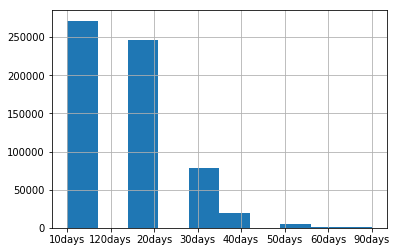

In [60]:
rest_prepared['buckets'].hist()

In [67]:
rest_prepared['buckets'].unique()

array(['20days', '10days', '40days', '30days', '60days', '50days',
       '90days', '120days'], dtype=object)

In [70]:
t = pd.DataFrame(rest_prepared.groupby("buckets").size().reset_index())
t.columns = ['buckets','size']
t

,buckets,size
0,10days,271489
1,120days,5
2,20days,246677
3,30days,78249
4,40days,19641
5,50days,5127
6,60days,1373
7,90days,443


In [71]:
t['size'].sum()

623004

## Write to a file

In [37]:
list = [rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11,rank12]

In [38]:
#Recall, 'a' append and 'w+' overwrite

f = open("list_DE.csv", 'w+')
for i in list:
    i.to_csv(f)
f.close()